# =========================
# Load libraries
# =========================

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import callbacks, layers, models
import keras_metrics as km
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tcake/coding_projects/python/opt_out/study-online-misogyny/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

# =========================
# Callbacks
# =========================

In [2]:
callbacks = [callbacks.TensorBoard(
    log_dir='log_trained_embeddings',
    histogram_freq=1,
    )
]

# =========================
# Load data
# =========================

In [3]:
# Load gold DATA
data = pd.read_csv("../../data/processed/stanford.csv")

train_data, test_data, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.2
)

# =========================
# Prepare data
# =========================

In [4]:
number_of_most_frequency_words = 20000
# Create unique index for every word and fit to training data
tokenizer = Tokenizer(num_words=number_of_most_frequency_words)
tokenizer.fit_on_texts(train_data)

# Turn each tweet into a sequence of integers of equal length
sequences = tokenizer.texts_to_sequences(train_data)
train_corpus_embeddings = pad_sequences(sequences)

# Print the number of unique words found in the data set (not the limit placed
# on the tokenizer), use this as feedback to the num_words arg of Tokenizer().
print("Found %d unique words." % len(tokenizer.word_index))

Found 54305 unique words.


# =========================
# Split data
# =========================

In [5]:
# Randomly shuffle data
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_corpus_embeddings = train_corpus_embeddings[indices]
train_labels = train_labels.values[indices]

# Split into training and validation data (approximately 80:20)
x_train = train_corpus_embeddings[:10410]
y_train = train_labels[:10410]
x_val   = train_corpus_embeddings[10410:]
y_val   = train_labels[10410:]

# =========================
# Build model
# =========================

In [6]:
# Add Embedding layer
# The final sigmoid layer outputs probability values between [0, 1]
model = models.Sequential()
model.add(layers.Embedding(number_of_most_frequency_words, 8, input_length=train_corpus_embeddings.shape[1]))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

# =========================
# Train model
# =========================



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10410 samples, validate on 14401 samples



Epoch 1/20
10410/10410 [==============================] - 1s 84us/step - loss: 0.6505 - precision: 0.6389 - recall: 0.9974 - val_loss: 0.6387 - val_precision: 0.6362 - val_recall: 1.0000
Epoch 2/20
10410/10410 [==============================] - 0s 37us/step - loss: 0.6258 - precision: 0.6423 - recall: 0.9970 - val_loss: 0.6230 - val_precision: 0.6535 - val_recall: 0.9823
Epoch 3/20
10410/10410 [==============================] - 1s 49us/step - loss: 0.6052 - precision: 0.6812 - recall: 0.9592 - val_loss: 0.6064 - val_precision: 0.6854 - val_recall: 0.9312
Epoch 4/20
10410/10410 [==============================] - 0s 42us/step - loss: 0.5841 - precision: 0.7070 - recall: 0.9181 - val_loss: 0.5914 - val_precision: 0.6980 - val_recall: 0.9132
Epoch 5/20
10410/10410 [==============================] - 1s 59us/step - loss: 0.5634 - precision: 0.7

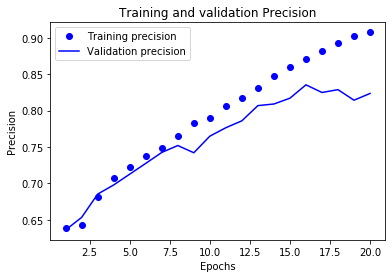

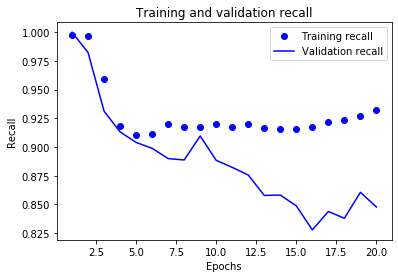

In [7]:
# As the model outputs probabilities, binary crossentropy is the best loss
# metric as it measures the distance between probability distributions
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=[km.binary_precision(), km.binary_recall()],
)

history = model.fit(
    x_train, y_train, epochs=20, batch_size=512, callbacks=callbacks, validation_data=(x_val, y_val)
)

# Prep history dictionary
precision = history.history["precision"]
val_precision = history.history["val_precision"]
recall = history.history["recall"]
val_recall = history.history["val_recall"]
epochs = range(1, len(precision) + 1)

# Plot the training and validation precision
plt.plot(epochs, precision, "bo", label="Training precision")
plt.plot(epochs, val_precision, "b", label="Validation precision")
plt.title("Training and validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.clf()
plt.plot(epochs, recall, "bo", label="Training recall")
plt.plot(epochs, val_recall, "b", label="Validation recall")
plt.title("Training and validation recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()


# =========================
# Evaluate on test data
# =========================

In [8]:
# DO NOT retrain the tokenizer. Use the argument oov_token=True to reserve a
# token for unkown words. See https://bit.ly/2lNh15g

# Prepare data
# Ensure sequences are padded to the same length as training data
x_sequences = tokenizer.texts_to_sequences(test_data)
x_test = pad_sequences(x_sequences, train_corpus_embeddings.shape[1])

# Prepare labels, transform to binary and float32
y_test = test_labels.values

# Print results as ['precision', 'recall'] check names with model.metrics_names
model.evaluate(x_test, y_test)[1:]


# Print results as ['precision', 'recall'] check names with model.metrics_names

6203/6203 [==============================] - 0s 31us/step


[0.8247704144744411, 0.8434010152070203]

# =========================
# F1 Score
# =========================

In [9]:
y_pred = model.predict(x_test, batch_size=32)
y_pred_roc = y_pred
y_pred = y_pred > 0.5
y_pred = y_pred.flatten()
y_pred = y_pred.astype(int)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("Marco F1:%f" % f1_score(y_test, y_pred, average="macro"))
print("Micro F1:%f" % f1_score(y_test, y_pred, average="micro"))
print("Weighted F1:%f" % f1_score(y_test, y_pred, average="weighted"))


Confusion matrix:
[[1557  706]
 [ 617 3323]]
Marco F1:0.767904
Micro F1:0.786716
Weighted F1:0.785768


# =========================
# ROC - AUC
# =========================
    

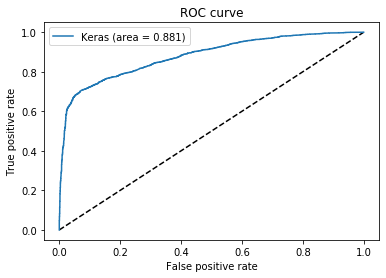

In [10]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_roc)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')